In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from collections import Counter
import math
from sklearn.metrics.pairwise import cosine_similarity

## Recall 200 based on itemCF

In [3]:

def get_sim_item(df_, user_col, item_col,  use_iif=True):

    df = df_.copy()
    user_item_ = df.groupby(user_col)[item_col].agg(list).reset_index()
    user_item_dict = dict(zip(user_item_[user_col], user_item_[item_col]))

    user_time_ = df.groupby(user_col)['time'].agg(list).reset_index() 
    user_time_dict = dict(zip(user_time_[user_col], user_time_['time']))

    sim_item = {}
    item_cnt = defaultdict(int)
    for user, items in tqdm(user_item_dict.items()):
        for loc1, item in enumerate(items):
            item_cnt[item] += 1
            sim_item.setdefault(item, {})
            for loc2, relate_item in enumerate(items):
                if item == relate_item:
                    continue
                t1 = user_time_dict[user][loc1]
                t2 = user_time_dict[user][loc2]
                sim_item[item].setdefault(relate_item, 0)
                if use_iif:
                    if loc1-loc2>0:
                        sim_item[item][relate_item] += 1 * 0.7 * (0.8**(loc1-loc2-1)) * (1 - (t1 - t2) * 10000) / math.log(1 + len(items)) # 逆向
                    else:
                        sim_item[item][relate_item] += 1 * 1.0 * (0.8**(loc2-loc1-1)) * (1 - (t2 - t1) * 10000) / math.log(1 + len(items)) # 正向
                else:
                    sim_item[item][relate_item] += 1 / math.log(1 + len(items))
    
    sim_item_corr = sim_item.copy()
    for i, related_items in tqdm(sim_item.items()):  
        for j, cij in related_items.items():  
            sim_item_corr[i][j] = cij / ((item_cnt[i] * item_cnt[j]) ** 0.2)

    return sim_item_corr, user_item_dict

def recommend(sim_item_corr, user_item_dict, user_id, top_k, item_num):

    rank = {}
    interacted_items = user_item_dict[user_id]
    interacted_items = interacted_items[::-1]
    for loc, i in enumerate(interacted_items):
        for j, wij in sorted(sim_item_corr[i].items(), reverse=True)[0:top_k]:
            if j not in interacted_items:
                rank.setdefault(j, 0)
                rank[j] += wij * (0.7**loc)
    return sorted(rank.items(), key=lambda d: d[1], reverse=True)[:item_num]


# fill user to 50 items
def get_predict(df, pred_col, top_fill):
    top_fill = [int(t) for t in top_fill.split(',')]
    scores = [-1 * i for i in range(1, len(top_fill) + 1)]
    ids = list(df['user_id'].unique())
    fill_df = pd.DataFrame(ids * len(top_fill), columns=['user_id'])
    fill_df.sort_values('user_id', inplace=True)
    fill_df['item_id'] = top_fill * len(ids)
    fill_df[pred_col] = scores * len(ids)
    df = df.append(fill_df)
    df.sort_values(pred_col, ascending=False, inplace=True)
    df = df.drop_duplicates(subset=['user_id', 'item_id'], keep='first')
    df['rank'] = df.groupby('user_id')[pred_col].rank(method='first', ascending=False)
    df = df[df['rank'] <= 50]
    df = df.groupby('user_id')['item_id'].apply(lambda x: ','.join([str(i) for i in x])).str.split(',', expand=True).reset_index()
    return df


if __name__ == "__main__":
    now_phase = 6
    train_path = './data/underexpose_train'
    test_path = 'underexpose_test'
    item_feat = pd.read_csv(train_path + '/underexpose_item_feat.csv', header=None)
    col_name_list = ["item_id"] + ["txt_vec_" + str(x) for x in range(128)] + ["img_vec_" + str(x) for x in range(128)]
    item_feat.columns = col_name_list
    item_feat['txt_vec_0'] = item_feat['txt_vec_0'].str.replace('[', '')
    item_feat['txt_vec_127'] = item_feat['txt_vec_127'].str.replace(']', '')
    item_feat['img_vec_0'] = item_feat['img_vec_0'].str.replace('[', '')
    item_feat['img_vec_127'] = item_feat['img_vec_127'].str.replace(']', '')
    recom_item = []
    all_click_test = pd.DataFrame()
    whole_click = pd.DataFrame()
    for c in range(now_phase + 1):
        print('phase:', c)
        test_path = './data/underexpose_test/underexpose_test_click-{}'.format(c)
        click_train = pd.read_csv(train_path + '/underexpose_train_click-{}.csv'.format(c), header=None,
                                  names=['user_id', 'item_id', 'time'])
        click_test = pd.read_csv(test_path + '/underexpose_test_click-{}.csv'.format(c), header=None,
                                 names=['user_id', 'item_id', 'time'])
        
        all_click = click_train.append(click_test)
        all_click_test = all_click_test.append(click_test)
        
        whole_click = whole_click.append(all_click)
        whole_click = whole_click.drop_duplicates(subset=['user_id', 'item_id', 'time'], keep='last')
        whole_click = whole_click.sort_values('time')
        
        

    
        item_sim_list, user_item = get_sim_item(whole_click, 'user_id', 'item_id', use_iif=True)

        for i in tqdm(click_test['user_id'].unique()):
            rank_item = recommend(item_sim_list, user_item, i, 10000, 200)
            for j in rank_item:
                recom_item.append([i, j[0], j[1]])
                # find most popular items
    top50_click = whole_click['item_id'].value_counts().index[:50].values
    top50_click = ','.join([str(i) for i in top50_click])

    recom_df = pd.DataFrame(recom_item, columns=['user_id', 'item_id', 'sim'])

phase: 0


100%|██████████| 1663/1663 [00:06<00:00, 268.32it/s]


phase: 1


100%|██████████| 1726/1726 [00:16<00:00, 101.72it/s]


phase: 2


100%|██████████| 1690/1690 [00:25<00:00, 66.84it/s] 


phase: 3


100%|██████████| 1675/1675 [00:49<00:00, 33.74it/s] 


phase: 4


100%|██████████| 1708/1708 [01:58<00:00, 14.42it/s]


phase: 5


100%|██████████| 1798/1798 [02:55<00:00, 10.22it/s] 


phase: 6


100%|██████████| 1821/1821 [03:31<00:00,  8.61it/s]


In [4]:
recom_df = recom_df[recom_df['sim']>0]

In [5]:
top_fill = [int(t) for t in top50_click.split(',')]

In [6]:
raw_result = get_predict(recom_df, 'sim', top50_click)

In [7]:
raw_result

,user_id,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,1,32360,74608,30677,101060,55390,67733,98382,54063,86677,...,43970,5509,73766,72251,11718,30474,98070,35247,38810,78059
1,2,18104,82469,10612,26837,95191,47855,26953,58191,38037,...,41958,96224,47271,38098,60219,4446,50494,43246,13606,84435
2,3,110798,28943,107129,17287,47382,87420,92379,47622,69717,...,97364,8134,77095,25682,59153,48832,50506,10716,94026,96087
3,11,26711,21517,10528,85475,40801,59376,77847,59255,13491,...,12148,21202,68918,54313,67096,51243,29768,2074,111494,64633
4,13,18663,106688,48498,114792,39182,42109,112207,78987,38202,...,100043,9769,72466,68038,114296,39192,19796,49992,39035,15579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12076,35426,99328,20179,26618,89709,60733,101826,17282,17213,17248,...,78841,3870,25985,713,80986,17691,58064,114051,42688,83525
12077,35434,60349,43017,67607,100949,84547,51493,68264,64550,59311,...,87826,34967,25244,9878,26410,27725,89798,44492,23876,40245
12078,35435,31115,91026,23634,34249,32280,44684,76173,25415,69642,...,2920,89333,105194,22421,19714,70232,91027,87982,97556,27827
12079,35436,29411,65775,87047,88033,15960,115973,92533,102379,98772,...,43196,57089,15998,8523,21618,31328,13826,86783,92706,39520


In [8]:
raw_result_copy = raw_result.copy()

In [9]:
user_item = whole_click.groupby('user_id')['item_id'].agg(list).reset_index()

In [10]:
user_item_dict = dict(zip(user_item['user_id'], user_item['item_id']))

In [11]:
user_feat = pd.read_csv(train_path + '/underexpose_user_feat.csv', header=None, names=['user_id','user_age_level','user_gender','user_city_level']) 

In [12]:
interaction_df = whole_click.copy()

In [13]:
interaction_df = pd.merge(left =interaction_df, right = user_feat, on = 'user_id' )

In [14]:
interaction_df_copy = interaction_df.copy()

In [15]:
interaction_df.dropna(how='any', inplace = True) 

In [16]:
interaction_df['user_gender'] = interaction_df['user_gender'].astype('category').cat.codes
interaction_df['user_city_level'] = interaction_df['user_city_level'].astype('int')
interaction_df['user_age_level'] = interaction_df['user_age_level'].astype('int')

In [17]:
item_group_gender_mode = interaction_df.groupby('item_id')['user_gender'].apply(lambda x: x.mode().iloc[0])

In [18]:
item_group_age_mode = interaction_df.groupby('item_id')['user_age_level'].apply(lambda x: x.mode().iloc[0])
item_group_city_mode = interaction_df.groupby('item_id')['user_city_level'].apply(lambda x: x.mode().iloc[0])

In [19]:
item_group_user_feat = pd.DataFrame({'item_id':item_group_gender_mode.index,'item_group_gender_mode':item_group_gender_mode.values})

In [20]:
item_group_user_feat = pd.merge(left=item_group_user_feat,right = item_group_age_mode,on='item_id')

In [21]:
item_group_user_feat = pd.merge(left=item_group_user_feat,right = item_group_city_mode,on='item_id')

In [22]:
item_freq = whole_click.groupby(['item_id'])['time'].count().reset_index()

In [23]:
item_freq.rename(columns={'time':'count'},inplace=True) 

In [24]:
item_group_user_feat = pd.merge(left=item_group_user_feat,right = item_freq,on='item_id')

In [25]:
item_group_user_feat.rename(columns={'user_age_level':'user_age_level_mode',
                                     'user_city_level':'user_city_level_mode'})

,item_id,item_group_gender_mode,user_age_level_mode,user_city_level_mode,count
0,1,1,5,6,4
1,3,0,4,2,16
2,4,0,3,5,4
3,5,0,6,2,4
4,6,0,4,2,3
...,...,...,...,...,...
81759,117644,0,5,1,5
81760,117646,0,5,1,7
81761,117660,0,5,6,12
81762,117663,0,3,4,5


## Construct test_qtime_df : use recom_df and qtime_click 

In [26]:
now_phase = 6
all_click_qtime = pd.DataFrame()
for c in range(now_phase + 1):
    print('phase:', c)
    test_path = './data/underexpose_test/underexpose_test_click-{}'.format(c)
    click_qtime = pd.read_csv(test_path + '/underexpose_test_qtime-{}.csv'.format(c), header=None,
                             names=['user_id', 'time'])
    all_click_qtime = all_click_qtime.append(click_qtime)

phase: 0
phase: 1
phase: 2
phase: 3
phase: 4
phase: 5
phase: 6


In [27]:
user_feat = pd.read_csv(train_path + '/underexpose_user_feat.csv', header=None, names=['user_id','user_age_level','user_gender','user_city_level']) 

In [28]:
user_feat.isnull().sum()

user_id             0
user_age_level     83
user_gender        81
user_city_level    22
dtype: int64

In [29]:
user_feat['user_gender'].fillna(user_feat['user_gender'].mode()[0],inplace=True)

In [30]:
user_feat['user_age_level'].fillna(user_feat['user_age_level'].mode()[0],inplace=True)

In [31]:
user_feat['user_city_level'].fillna(user_feat['user_city_level'].mode()[0],inplace=True)

In [32]:
all_click_qtime_merge = pd.merge(left = all_click_qtime, right = user_feat,how = 'left' ,on='user_id')

In [33]:
all_click_qtime_with_feat = all_click_qtime_merge.dropna(how='any') 

In [34]:
all_click_qtime_with_feat 

,user_id,time,user_age_level,user_gender,user_city_level
6,99,0.983946,6.0,M,6.0
7,132,0.983954,6.0,M,1.0
12,242,0.983952,8.0,F,2.0
19,352,0.983947,5.0,F,3.0
20,363,0.983957,5.0,F,4.0
...,...,...,...,...,...
12055,34964,0.984249,4.0,F,1.0
12057,35019,0.984258,6.0,F,2.0
12059,35052,0.984253,1.0,F,6.0
12064,35140,0.984284,8.0,M,2.0


In [35]:
tmp_df = pd.merge(left = recom_df, right = all_click_qtime_with_feat, how = 'left', on='user_id' )

In [36]:
test_qtime_df = tmp_df.dropna(how='any') 

In [37]:
tmp_df = pd.merge(left = test_qtime_df, right = item_feat, how = 'left', on='item_id' )

In [38]:
test_qtime_df = tmp_df.dropna(how='any') 

In [39]:
test_qtime_df

,user_id,item_id,sim,time,user_age_level,user_gender,user_city_level,txt_vec_0,txt_vec_1,txt_vec_2,...,img_vec_118,img_vec_119,img_vec_120,img_vec_121,img_vec_122,img_vec_123,img_vec_124,img_vec_125,img_vec_126,img_vec_127
0,6941,55377,0.272711,0.983956,5.0,F,1.0,4.538931369781494,-1.462644,0.783198,...,1.087873,-2.553088,-0.406455,-5.166473,-0.569335,3.841423,-0.687411,0.828711,2.384133,0.3026016354560852
1,6941,1754,0.200566,0.983956,5.0,F,1.0,4.001996040344238,-0.954806,0.772922,...,-0.959451,0.260769,2.256252,-2.430656,6.504451,2.616828,0.643946,2.965229,1.214263,-0.007721424102783203
2,6941,53466,0.188164,0.983956,5.0,F,1.0,3.7488536834716797,-1.479562,0.473005,...,0.095562,-1.494505,1.659091,-1.011158,4.989762,1.924683,2.087282,3.262639,2.545196,-0.11715996265411377
3,6941,98002,0.154011,0.983956,5.0,F,1.0,2.1262454986572266,-3.844370,2.068913,...,0.310329,-2.064125,1.250575,1.995727,8.720922,3.865652,3.694909,2.092307,1.131385,-1.3908246755599976
4,6941,112916,0.149169,0.983956,5.0,F,1.0,1.359130620956421,0.725365,0.898401,...,0.395642,-3.459770,3.855214,-1.709294,0.865939,-3.765583,0.764212,2.974474,2.328575,1.6805479526519775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547268,18805,68472,0.010270,0.984258,3.0,M,6.0,3.1247715950012207,-1.663266,2.284492,...,-0.562017,0.958513,2.495924,-1.250975,-0.734809,2.432478,2.106185,2.217091,0.414016,1.2776352167129517
547269,18805,76322,0.010253,0.984258,3.0,M,6.0,3.6110215187072754,-0.236572,1.909966,...,-0.545139,-1.825327,1.069047,-3.120861,-0.502128,1.711405,1.096174,1.123895,2.224453,1.308835506439209
547270,18805,98449,0.010159,0.984258,3.0,M,6.0,4.558124542236328,0.883429,2.995629,...,2.037077,-3.481366,1.002489,-1.100875,-0.447404,1.913569,1.912527,3.684313,1.863195,-3.0323102474212646
547271,18805,19564,0.010078,0.984258,3.0,M,6.0,3.309978723526001,0.333133,0.656455,...,2.340028,-0.007701,-0.130290,0.359640,1.396708,3.700938,0.743083,1.418326,-0.664997,2.252328634262085


- contruct completed! The task is to predict labels for the test_qtime_df

## Construct train & valid: 
### use last click in test_click(label1) and recom_df_test_click(label 0)

### get label 1

In [40]:
now_phase = 6
all_click_test = pd.DataFrame()
for c in range(now_phase + 1):
    print('phase:', c)
    test_path = './data/underexpose_test/underexpose_test_click-{}'.format(c)
    click_test = pd.read_csv(test_path + '/underexpose_test_click-{}.csv'.format(c), header=None,
                             names=['user_id', 'item_id', 'time'])
    all_click_test = all_click_test.append(click_test)

phase: 0
phase: 1
phase: 2
phase: 3
phase: 4
phase: 5
phase: 6


In [41]:
all_click_test = all_click_test.sort_values('time')

In [42]:
latest_click_test = all_click_test.groupby('user_id', as_index=False).tail(1)

In [43]:
latest_click_test

,user_id,item_id,time
541,22946,102303,0.983740
14900,22352,41533,0.983740
20690,20922,13603,0.983741
6518,34496,20710,0.983742
8907,15290,111807,0.983744
...,...,...,...
21306,22325,72356,0.984285
3692,20499,24448,0.984285
11548,2316,36988,0.984285
4532,10665,19323,0.984285


In [45]:
if __name__ == "__main__":
    now_phase = 6
    train_path = './data/underexpose_train'
    test_path = 'underexpose_test'
    
    recom_item = []
    all_click_test = pd.DataFrame()
    whole_click = pd.DataFrame()
    for c in range(now_phase + 1):
        print('phase:', c)
        test_path = './data/underexpose_test/underexpose_test_click-{}'.format(c)
        click_train = pd.read_csv(train_path + '/underexpose_train_click-{}.csv'.format(c), header=None,
                                  names=['user_id', 'item_id', 'time'])
        click_test = pd.read_csv(test_path + '/underexpose_test_click-{}.csv'.format(c), header=None,
                                 names=['user_id', 'item_id', 'time'])
        
        click_test_drop_last = pd.merge(click_test, latest_click_test, how='outer', indicator=True)
        click_test_drop_last_df = click_test_drop_last.loc[click_test_drop_last._merge == 'left_only', ['user_id','item_id','time']]
        
        all_click = click_train.append(click_test_drop_last_df)
        all_click_test = all_click_test.append(click_test_drop_last_df)
        
        whole_click = whole_click.append(all_click)
        whole_click = whole_click.drop_duplicates(subset=['user_id', 'item_id', 'time'], keep='last')
        whole_click = whole_click.sort_values('time')
        
        item_sim_list, user_item = get_sim_item(whole_click, 'user_id', 'item_id', use_iif=True)

        for i in tqdm(click_test['user_id'].unique()):
            rank_item = recommend(item_sim_list, user_item, i, 10000, 200)
            for j in rank_item:
                recom_item.append([i, j[0], j[1]])
                # find most popular items
    top50_click = whole_click['item_id'].value_counts().index[:50].values
    top50_click = ','.join([str(i) for i in top50_click])

    recom_df_test = pd.DataFrame(recom_item, columns=['user_id', 'item_id', 'sim'])

phase: 0


100%|██████████| 1663/1663 [00:07<00:00, 217.81it/s]


phase: 1


100%|██████████| 1726/1726 [00:15<00:00, 111.11it/s]


phase: 2


100%|██████████| 1690/1690 [00:23<00:00, 70.79it/s] 


phase: 3


100%|██████████| 1675/1675 [00:46<00:00, 35.98it/s] 


phase: 4


100%|██████████| 1708/1708 [01:19<00:00, 21.56it/s] 


phase: 5


100%|██████████| 1798/1798 [02:15<00:00, 13.24it/s] 


phase: 6


100%|██████████| 1821/1821 [03:15<00:00,  9.29it/s]


In [46]:
tmp = pd.merge(left = recom_df_test, right = latest_click_test,how='outer', on=['user_id','item_id'])

In [47]:
tmp = tmp[tmp['sim'].notna()]

In [48]:
recom_df_test = tmp.assign(label=np.where(tmp['time'].isnull(), 0, 1))

In [49]:
recom_df_test.drop(['time'],axis=1,inplace=True)

In [50]:
recom_df_test

,user_id,item_id,sim,label
0,1133,96668,0.250660,0
1,1133,116083,0.217613,0
2,1133,95025,0.182241,0
3,1133,88942,0.179372,0
4,1133,49396,0.162546,0
...,...,...,...,...
2387901,6892,80058,0.017570,0
2387902,6892,18753,0.017536,0
2387903,6892,56688,0.017436,0
2387904,6892,106820,0.017280,0


In [51]:
my_train_df = pd.merge(left = recom_df_test, right = user_feat,how = 'left' ,on='user_id')

In [52]:
my_train_df = my_train_df.dropna(how='any') 

In [53]:
my_train_df = pd.merge(left = my_train_df, right = item_feat,how = 'left' ,on='item_id')

In [54]:
my_train_df = my_train_df.dropna(how='any') 

In [55]:
my_train_df = my_train_df.astype({"user_age_level": int, "user_city_level": int})

In [56]:
Counter(my_train_df['label'])

Counter({0: 490667, 1: 312})

- in this recall_500 experiment, only 312/490667 has positive label.

# Re-rank by LightGBM

In [57]:
my_train_df

,user_id,item_id,sim,label,user_age_level,user_gender,user_city_level,txt_vec_0,txt_vec_1,txt_vec_2,...,img_vec_118,img_vec_119,img_vec_120,img_vec_121,img_vec_122,img_vec_123,img_vec_124,img_vec_125,img_vec_126,img_vec_127
0,6941,55377,0.193634,0,5,F,1,4.538931369781494,-1.462644,0.783198,...,1.087873,-2.553088,-0.406455,-5.166473,-0.569335,3.841423,-0.687411,0.828711,2.384133,0.3026016354560852
1,6941,62646,0.154202,0,5,F,1,0.2432735562324524,-3.233713,1.187783,...,0.276463,-1.320294,0.687789,0.301658,5.064686,5.211863,4.390013,2.785665,-0.249005,-0.8128962516784668
2,6941,51933,0.145556,0,5,F,1,2.1751604080200195,0.495418,-1.831361,...,1.127423,-0.068791,-0.045543,-4.337142,-0.843006,-0.617695,1.240992,1.414151,1.674937,-2.899440288543701
3,6941,14860,0.143047,0,5,F,1,0.3861796259880066,-2.375436,0.483239,...,3.280613,-1.286619,1.301653,-4.165394,-0.271072,1.500205,1.350353,2.502652,1.300839,-1.2214959859848022
4,6941,20442,0.138724,0,5,F,1,2.132089376449585,-2.106760,1.004567,...,-1.120101,1.890993,3.722258,-2.943218,2.920215,2.160486,0.502558,3.177566,1.487555,2.199732780456543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546054,18805,109138,0.010885,0,3,M,6,0.8901849985122681,0.042669,2.842594,...,0.416093,-0.917160,-0.028134,2.624365,1.574156,-0.014772,2.250575,2.005705,0.309760,0.9139738082885742
546055,18805,9164,0.010620,0,3,M,6,3.039198398590088,-3.876892,-4.194433,...,-1.855832,-1.760940,3.823716,0.099272,-1.340564,0.737038,3.145404,3.209418,2.876270,-1.1992589235305786
546057,18805,92037,0.010119,0,3,M,6,3.9074246883392334,2.595945,3.332915,...,-2.890127,-0.484596,-0.261324,2.161624,-0.369042,0.998419,-0.048171,0.889278,-1.605629,-1.1206083297729492
546058,18805,75377,0.010023,0,3,M,6,2.2413933277130127,3.067715,2.870929,...,-3.416262,-2.142343,-3.265679,0.372683,1.908428,0.902621,-2.337928,0.711182,0.926438,3.372680187225342


In [58]:
my_train_df.columns

Index(['user_id', 'item_id', 'sim', 'label', 'user_age_level', 'user_gender',
       'user_city_level', 'txt_vec_0', 'txt_vec_1', 'txt_vec_2',
       ...
       'img_vec_118', 'img_vec_119', 'img_vec_120', 'img_vec_121',
       'img_vec_122', 'img_vec_123', 'img_vec_124', 'img_vec_125',
       'img_vec_126', 'img_vec_127'],
      dtype='object', length=263)

In [59]:
target = 'label'
categorical = ['user_age_level', 'user_city_level','user_gender']

In [60]:
predictors = list(my_train_df.columns)

In [61]:
del predictors[:2]

In [62]:
del predictors[1]

In [63]:
predictors

['sim',
 'user_age_level',
 'user_gender',
 'user_city_level',
 'txt_vec_0',
 'txt_vec_1',
 'txt_vec_2',
 'txt_vec_3',
 'txt_vec_4',
 'txt_vec_5',
 'txt_vec_6',
 'txt_vec_7',
 'txt_vec_8',
 'txt_vec_9',
 'txt_vec_10',
 'txt_vec_11',
 'txt_vec_12',
 'txt_vec_13',
 'txt_vec_14',
 'txt_vec_15',
 'txt_vec_16',
 'txt_vec_17',
 'txt_vec_18',
 'txt_vec_19',
 'txt_vec_20',
 'txt_vec_21',
 'txt_vec_22',
 'txt_vec_23',
 'txt_vec_24',
 'txt_vec_25',
 'txt_vec_26',
 'txt_vec_27',
 'txt_vec_28',
 'txt_vec_29',
 'txt_vec_30',
 'txt_vec_31',
 'txt_vec_32',
 'txt_vec_33',
 'txt_vec_34',
 'txt_vec_35',
 'txt_vec_36',
 'txt_vec_37',
 'txt_vec_38',
 'txt_vec_39',
 'txt_vec_40',
 'txt_vec_41',
 'txt_vec_42',
 'txt_vec_43',
 'txt_vec_44',
 'txt_vec_45',
 'txt_vec_46',
 'txt_vec_47',
 'txt_vec_48',
 'txt_vec_49',
 'txt_vec_50',
 'txt_vec_51',
 'txt_vec_52',
 'txt_vec_53',
 'txt_vec_54',
 'txt_vec_55',
 'txt_vec_56',
 'txt_vec_57',
 'txt_vec_58',
 'txt_vec_59',
 'txt_vec_60',
 'txt_vec_61',
 'txt_vec_62',
 '

In [66]:
my_train_df_copy = my_train_df.copy()

In [67]:
train_test_valid = my_train_df_copy.append(test_qtime_df)

In [68]:
train_test_valid['txt_vec_0'] =train_test_valid['txt_vec_0'].astype(float)

In [69]:
train_test_valid['user_gender'] = train_test_valid['user_gender'].astype('category').cat.codes
train_test_valid['user_city_level'] = train_test_valid['user_city_level'].astype('category')
train_test_valid['user_age_level'] = train_test_valid['user_age_level'].astype('category')

In [70]:

len_train = len(my_train_df)
val_size= len_train // 10
test_df = train_test_valid[len_train:]
val_df = train_test_valid[(len_train-val_size):len_train]
train_df = train_test_valid[:(len_train-val_size)]

In [71]:
y_val = val_df['label']
y_train = train_df['label']

In [72]:
X_train = train_df.drop(['user_id','item_id','label'],axis=1)

In [73]:
X_val = val_df.drop(['user_id','item_id','label'],axis=1)

In [81]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=150, num_boost_round=3000, verbose_eval=10, categorical_features=categorical):
    lgb_params = {
        'target': target,
        'boosting_type': 'gbdt',
        'objective': objective,
        'learning_rate': 0.05,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 15,  # 2^max_depth - 1
        'max_depth': 4,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 500,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 1,#0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':330, # because training data is extremely unbalanced 
        'metric': 'auc' 
    }

    lgb_params.update(params)

    print("preparing validation datasets")


    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    

    
    del dtrain
    del dvalid
    gc.collect()

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[ xgvalid], 
                     valid_names=['valid'],
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     categorical_feature=categorical_features,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return (bst1,bst1.best_iteration)

In [82]:
import time
# import time
print("Training...")
start_time = time.time()

params = {
        'learning_rate': 0.05,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 15,  # 2^max_depth - 1
        'max_depth': 4,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 500,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 1,#0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':330, # because training data is extremely unbalanced 
        'metric': 'auc'  
    }
(bst,best_iteration) = lgb_modelfit_nocv(params, 
                            train_df, 
                            val_df, 
                            predictors, 
                            target, 
                            objective='binary', 
                            metrics='auc',
                            early_stopping_rounds=200, 
                            verbose_eval=True, 
                            num_boost_round=500, 
                            categorical_features=categorical)

print('[{}]: model training time'.format(time.time() - start_time))

Training...
preparing validation datasets
Training until validation scores don't improve for 200 rounds
[10]	valid's auc: 0.697114
[20]	valid's auc: 0.752678
[30]	valid's auc: 0.764897
[40]	valid's auc: 0.69492
[50]	valid's auc: 0.727067
[60]	valid's auc: 0.740077
[70]	valid's auc: 0.779156
[80]	valid's auc: 0.782392
[90]	valid's auc: 0.786861
[100]	valid's auc: 0.781268
[110]	valid's auc: 0.777805
[120]	valid's auc: 0.776487
[130]	valid's auc: 0.776475
[140]	valid's auc: 0.777375
[150]	valid's auc: 0.784097
[160]	valid's auc: 0.781834
[170]	valid's auc: 0.784227
[180]	valid's auc: 0.784775
[190]	valid's auc: 0.785958
[200]	valid's auc: 0.784885
[210]	valid's auc: 0.781712
[220]	valid's auc: 0.780782
[230]	valid's auc: 0.778088
[240]	valid's auc: 0.778579
[250]	valid's auc: 0.775022
[260]	valid's auc: 0.770119
[270]	valid's auc: 0.765853
[280]	valid's auc: 0.762328
[290]	valid's auc: 0.757336
[300]	valid's auc: 0.756988
[310]	valid's auc: 0.75435
[320]	valid's auc: 0.746136
[330]	valid

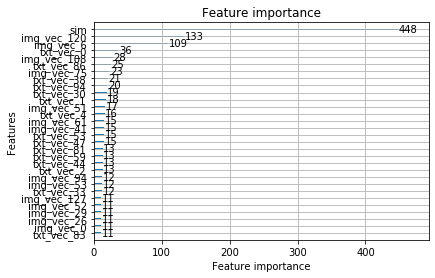

In [83]:
ax = lgb.plot_importance(bst, max_num_features=30)
plt.show()

In [84]:
test_df['txt_vec_127'] = test_df['txt_vec_127'].astype('float') 
test_df['img_vec_0'] = test_df['img_vec_0'].astype('float')
test_df['img_vec_127'] = test_df['img_vec_127'].astype('float')

/Users/mengkeyang/Documents/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mengkeyang/Documents/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mengkeyang/Documents/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [85]:
test_df['label'] = bst.predict(test_df[predictors],num_iteration=best_iteration)

/Users/mengkeyang/Documents/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [86]:
test_df

,user_id,item_id,sim,label,user_age_level,user_gender,user_city_level,txt_vec_0,txt_vec_1,txt_vec_2,...,img_vec_119,img_vec_120,img_vec_121,img_vec_122,img_vec_123,img_vec_124,img_vec_125,img_vec_126,img_vec_127,time
0,6941,55377,0.272711,0.586594,5.0,0,1.0,4.538931,-1.462644,0.783198,...,-2.553088,-0.406455,-5.166473,-0.569335,3.841423,-0.687411,0.828711,2.384133,0.302602,0.983956
1,6941,1754,0.200566,0.209259,5.0,0,1.0,4.001996,-0.954806,0.772922,...,0.260769,2.256252,-2.430656,6.504451,2.616828,0.643946,2.965229,1.214263,-0.007721,0.983956
2,6941,53466,0.188164,0.000000,5.0,0,1.0,3.748854,-1.479562,0.473005,...,-1.494505,1.659091,-1.011158,4.989762,1.924683,2.087282,3.262639,2.545196,-0.117160,0.983956
3,6941,98002,0.154011,0.041722,5.0,0,1.0,2.126245,-3.844370,2.068913,...,-2.064125,1.250575,1.995727,8.720922,3.865652,3.694909,2.092307,1.131385,-1.390825,0.983956
4,6941,112916,0.149169,0.512502,5.0,0,1.0,1.359131,0.725365,0.898401,...,-3.459770,3.855214,-1.709294,0.865939,-3.765583,0.764212,2.974474,2.328575,1.680548,0.983956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547268,18805,68472,0.010270,0.017263,3.0,1,6.0,3.124772,-1.663266,2.284492,...,0.958513,2.495924,-1.250975,-0.734809,2.432478,2.106185,2.217091,0.414016,1.277635,0.984258
547269,18805,76322,0.010253,0.011954,3.0,1,6.0,3.611022,-0.236572,1.909966,...,-1.825327,1.069047,-3.120861,-0.502128,1.711405,1.096174,1.123895,2.224453,1.308836,0.984258
547270,18805,98449,0.010159,0.007864,3.0,1,6.0,4.558125,0.883429,2.995629,...,-3.481366,1.002489,-1.100875,-0.447404,1.913569,1.912527,3.684313,1.863195,-3.032310,0.984258
547271,18805,19564,0.010078,0.003022,3.0,1,6.0,3.309979,0.333133,0.656455,...,-0.007701,-0.130290,0.359640,1.396708,3.700938,0.743083,1.418326,-0.664997,2.252329,0.984258


In [87]:
test_df['new_label'] = 0.3*test_df['label'] + 0.7*test_df['sim'] 

/Users/mengkeyang/Documents/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
result = get_predict(test_df, 'new_label', top50_click)

In [89]:
result

,user_id,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,13,35335,18663,39182,106688,114792,48498,52844,89770,65417,...,90109,49992,40179,70808,72466,22971,114296,44704,327,108567
1,16,87818,111716,36855,106225,106215,87200,103577,86218,21858,...,100124,89888,45253,51652,107962,92440,92723,103062,51176,108432
2,17,107085,82497,51315,86019,18789,63153,104962,99746,84109,...,59155,63628,37439,111866,38696,53466,51431,91476,108854,89883
3,26,36071,110172,89524,94852,78868,70650,90006,8291,85661,...,107735,89864,8324,81144,65285,14217,86191,70844,106798,106741
4,35,8337,82039,92016,63851,58647,38254,113203,115141,36054,...,35433,31905,83116,20513,84932,34792,57659,96526,68662,113809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,35279,2519,3617,102547,10040,57468,24880,22430,102784,115679,...,2410,2422,11860,24843,8179,5043,38415,28021,8151,35264
2741,35280,86752,33918,38233,42865,14217,77617,79347,52261,92734,...,75041,53631,67473,111334,36728,41167,54560,71092,91802,95057
2742,35304,15307,45473,35244,75985,84511,12279,64933,101918,41432,...,72088,56586,40345,82890,10476,10794,88136,111374,22640,141
2743,35305,37330,46199,9663,47885,51467,40289,65262,97330,28461,...,42185,86076,51742,82808,70092,61243,86527,78342,84959,5101


### For users that have features, replace their recommendation based on re-ranking result

In [90]:
replace_user = result['user_id'].unique()

In [91]:
final_res = pd.DataFrame()
for index, row in raw_result.iterrows():
    if row['user_id'] in replace_user:
        final_res=final_res.append(result[result['user_id']==row['user_id']])
    else:
        final_res=final_res.append(row)

In [92]:
final_res['user_id'] = final_res['user_id'].astype(int)

In [94]:
cols = final_res.columns.tolist()
cols = cols[-1:] + cols[:-1]
final_res = final_res[cols]

In [95]:
final_res

,user_id,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,1,32360,74608,30677,101060,55390,67733,98382,54063,86677,...,43970,5509,73766,72251,11718,30474,98070,35247,38810,78059
1,2,18104,82469,10612,26837,95191,47855,26953,58191,38037,...,41958,96224,47271,38098,60219,4446,50494,43246,13606,84435
2,3,110798,28943,107129,17287,47382,87420,92379,47622,69717,...,97364,8134,77095,25682,59153,48832,50506,10716,94026,96087
3,11,26711,21517,10528,85475,40801,59376,77847,59255,13491,...,12148,21202,68918,54313,67096,51243,29768,2074,111494,64633
0,13,35335,18663,39182,106688,114792,48498,52844,89770,65417,...,90109,49992,40179,70808,72466,22971,114296,44704,327,108567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12076,35426,99328,20179,26618,89709,60733,101826,17282,17213,17248,...,78841,3870,25985,713,80986,17691,58064,114051,42688,83525
12077,35434,60349,43017,67607,100949,84547,51493,68264,64550,59311,...,87826,34967,25244,9878,26410,27725,89798,44492,23876,40245
12078,35435,31115,91026,23634,34249,32280,44684,76173,25415,69642,...,2920,89333,105194,22421,19714,70232,91027,87982,97556,27827
12079,35436,29411,65775,87047,88033,15960,115973,92533,102379,98772,...,43196,57089,15998,8523,21618,31328,13826,86783,92706,39520
